## Project Plan

- Data loading and exploration: This involves loading the dataset and understanding its structure.
- Data preprocessing: This might involve cleaning the text data (removing special characters, stop words, etc.), tokenizing, and converting the text to sequences of numbers.
- Model building: We will create a sentiment analysis model. We could use various models like logistic regression, Naive Bayes, or even deep learning models like RNNs or transformers. The choice of model depends on the dataset and the complexity of the task.
- Training: We will train the model using our preprocessed data.
- Evaluation: We will evaluate the model's performance on a separate test dataset.


In [ ]:
import pandas as pd

# Load the data
data = pd.read_csv('/workspaces/codespaces-jupyter/data/Tweets.csv')

# Display the first few rows of the dataframe
data.head()


The dataset contains several columns, but for our sentiment analysis model, the most important ones are:

- `text`: This is the text of the tweet, which we will use as our feature for the model.
- `airline_sentiment`: This is the sentiment of the tweet (positive, neutral, or negative), which we will use as our target variable.

We have other information available as well, such as the airline, the reason for a negative sentiment, and the confidence of the sentiment. While this information could be used in a more complex model or for a more detailed analysis, we will focus on the `text` and `airline_sentiment` for our sentiment analysis model.

Now, let's proceed to the next step: data preprocessing. This involves cleaning the text data and converting it into a numerical format that our model can understand. We will:

- Clean the text data: We'll remove any special characters, URLs, numbers, and stop words.
- Tokenize the text: This is the process of converting text into individual words (or tokens).
- Convert the tokens to sequences of numbers: We'll create a dictionary mapping each word to a unique number, and then we'll use this dictionary to convert our tokens into sequences of numbers.

But before we start with the preprocessing, let's check for missing values in our important columns. We'll also look at the distribution of the airline_sentiment column to understand the balance of classes in our dataset. This is important because if our dataset is highly imbalanced, it might affect the performance of our model.

In [ ]:
# Check for missing values in 'text' and 'airline_sentiment' columns
missing_values = data[['text', 'airline_sentiment']].isnull().sum()

# Check the distribution of 'airline_sentiment'
sentiment_distribution = data['airline_sentiment'].value_counts()

missing_values, sentiment_distribution


In [ ]:
# Drop unimportant columns
data_clean = data.drop(['tweet_id', 'negativereason', 'negativereason_confidence', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone', 'airline_sentiment_confidence'], axis=1)

# Display the first few rows of the cleaned dataset
data_clean.head()


In [ ]:
# Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

# Download necessary NLTK data
nltk.download(['punkt', 'wordnet', 'stopwords'])

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the stopword list
stopwords = set(stopwords.words('english'))

# Define a function to preprocess the text
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords, airline tags, and lemmatize the words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords and not word.startswith('@')]

    # Join the tokens back into a single string and return it
    return ' '.join(tokens)

# Apply the function to the text column
data_clean['text'] = data_clean['text'].apply(preprocess_text)

In [ ]:
data_clean[['text', 'airline_sentiment']].head()

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Load the BERT model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a function to generate BERT embeddings for a piece of text
def generate_bert_embeddings(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    # Generate the embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the embeddings from the last hidden state
    # We use the mean of the token-level embeddings as the sentence-level embedding
    embeddings = outputs.last_hidden_state.mean(dim=1)

    return embeddings.numpy().flatten()

# Generate BERT embeddings for all the text data
bert_embeddings = data_clean['text'].apply(generate_bert_embeddings)


In [ ]:
import numpy as np

# Save the embeddings
np.save('bert_embeddings.npy', bert_embeddings)


In [12]:
# import bert embeddings
import numpy as np
bert_embeddings = np.load('bert_embeddings.npy', allow_pickle=True)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np

# Convert the target variable into numerical form
y = data_clean['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}).values

# Create a 2D numpy array from the list of embeddings
X = np.stack(bert_embeddings)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train a Logistic Regression model
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)


# Predict the sentiment for the test data
y_pred = clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1889
           1       0.56      0.50      0.53       580
           2       0.69      0.65      0.67       459

    accuracy                           0.77      2928
   macro avg       0.70      0.68      0.68      2928
weighted avg       0.76      0.77      0.76      2928



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
from sklearn.metrics import accuracy_score

# Predict the sentiment for the training data
y_train_pred = clf.predict(X_train)

# Calculate the accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate the accuracy on the validation set
test_accuracy = accuracy_score(y_test, y_pred)

print('Training Accuracy: ', train_accuracy)
print('Validation Accuracy: ', test_accuracy)



Training Accuracy:  0.8150614754098361
Validation Accuracy:  0.766051912568306


In [22]:
def predict_sentiment(text):
    # Preprocess the text
    preprocessed_text = preprocess_text(text)

    # Generate BERT embeddings
    embeddings = generate_bert_embeddings(preprocessed_text)

    # Make sure to reshape the embeddings to a 2D array
    embeddings = embeddings.reshape(1, -1)

    # Use the model to predict the sentiment
    sentiment = clf.predict(embeddings)

    # Map the sentiment back to a label
    sentiment_label = {0: 'negative', 1: 'neutral', 2: 'positive'}[sentiment[0]]

    return sentiment_label

# Test the function with a new input
text, sentiment = "This is a great day!", predict_sentiment("This is a great day!")
print(f'Text : {text}', f'Sentiment : {sentiment}', sep='\n')
text, sentiment = "This is a bad day!", predict_sentiment("This is a bad day!")
print(f'Text : {text}', f'Sentiment : {sentiment}', sep='\n')

Text : This is a great day!
Sentiment : positive
Text : This is a bad day!
Sentiment : negative


In [18]:
from sklearn import svm

# Train a SVM model
clf_svm = svm.SVC().fit(X_train, y_train)

# Predict the sentiment for the test data
y_pred_svm = clf_svm.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred_svm))


              precision    recall  f1-score   support

           0       0.82      0.92      0.86      1889
           1       0.60      0.48      0.53       580
           2       0.79      0.61      0.69       459

    accuracy                           0.78      2928
   macro avg       0.74      0.67      0.70      2928
weighted avg       0.77      0.78      0.77      2928



In [24]:
def predict_sentiment(text):
    # Preprocess the text
    preprocessed_text = preprocess_text(text)

    # Generate BERT embeddings
    embeddings = generate_bert_embeddings(preprocessed_text)

    # Make sure to reshape the embeddings to a 2D array
    embeddings = embeddings.reshape(1, -1)

    # Use the model to predict the sentiment
    sentiment = clf_svm.predict(embeddings)

    # Map the sentiment back to a label
    sentiment_label = {0: 'negative', 1: 'neutral', 2: 'positive'}[sentiment[0]]

    return text, sentiment_label

# Test the function with a new input
text, sentiment = predict_sentiment("I very much love flying with Air Canada!")
print(f'Text: {text}\nSentiment: {sentiment}')

text, sentiment = predict_sentiment("US Airline industry is in shambles!")
print(f'Text: {text}\nSentiment: {sentiment}')


Text: I very much love flying with Air Canada!
Sentiment: positive
Text: US Airline industry is in shambles!
Sentiment: negative


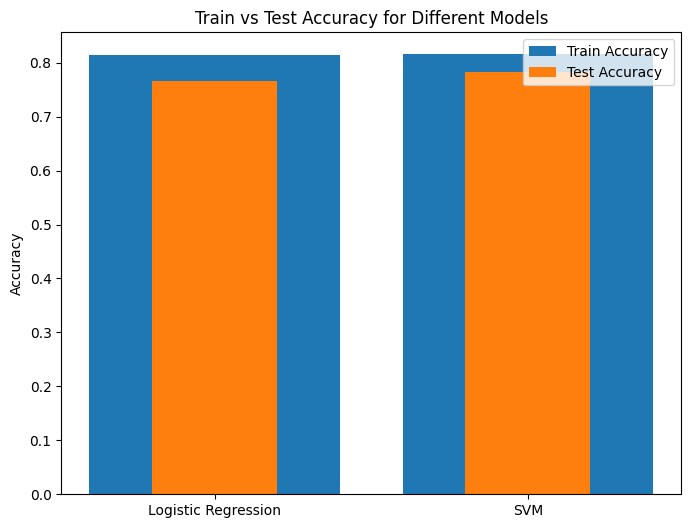

In [25]:
import matplotlib.pyplot as plt

# Calculate the training set accuracy
train_accuracy_lr = clf.score(X_train, y_train)
test_accuracy_lr = clf.score(X_test, y_test)

train_accuracy_svm = clf_svm.score(X_train, y_train)
test_accuracy_svm = clf_svm.score(X_test, y_test)

# Plot the accuracies
plt.figure(figsize=(8, 6))
plt.bar(['Logistic Regression', 'SVM'], [train_accuracy_lr, train_accuracy_svm], label='Train Accuracy')
plt.bar(['Logistic Regression', 'SVM'], [test_accuracy_lr, test_accuracy_svm], label='Test Accuracy', width=0.4)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Different Models')
plt.show()


In [26]:
import joblib

# Save the logistic regression model
joblib.dump(clf, 'logistic_regression_model.pkl')

# Save the SVM model
joblib.dump(clf_svm, 'svm_model.pkl')


['svm_model.pkl']

## Convolutional Neural Network (CNN) for Sentiment Classification

In [27]:
# import necessary libraries for building and training the model
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


2023-06-16 23:57:28.334178: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 23:57:30.896700: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 23:57:30.898072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 23:57:35.479297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [28]:
# Convert the target variable into a one-hot encoded format, which is the format required for multiclass classification in Keras
# Initialize a LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder to the labels
y_encoded = le.fit_transform(y)

# One-hot encode the labels
y_onehot = to_categorical(y_encoded)


In [29]:
from sklearn.model_selection import train_test_split

# Split the data into a training set and a temporary set using an 80-20 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Split the temporary set into a validation set and a test set using a 50-50 split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [56]:
# Determine the number of features in our input data
input_dim = X_train.shape[1]

# Determine the number of classes in our target variable
num_classes = y_onehot.shape[1]

# Initialize a sequential model
model = Sequential()

# Add an input layer with kernel regularization of L2 type = 0.01
model.add(Dense(512, input_dim=input_dim, activation='relu', kernel_regularizer='l2'))


# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a hidden layer with kernel regularization of L2 type = 0.01
model.add(Dense(512, activation='relu', kernel_regularizer='l2'))

# Add an output layer with kernel regularization of L2 type = 0.01
model.add(Dense(num_classes, activation='softmax', kernel_regularizer='l2'))


In [70]:
from keras.regularizers import l2

# Determine the number of features in our input data
input_dim = X_train.shape[1]

# Determine the number of classes in our target variable
num_classes = y_onehot.shape[1]

# Initialize a sequential model
model = Sequential()

# Add an input layer with L2 regularization
model.add(Dense(512, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a hidden layer with L2 regularization and 'tanh' activation
model.add(Dense(256, activation='tanh', kernel_regularizer=l2(0.001)))

# Add another dropout layer
model.add(Dropout(0.5))

# Add another hidden layer with L2 regularization and 'tanh' activation
model.add(Dense(128, activation='tanh', kernel_regularizer=l2(0.001)))

# Add another dropout layer
model.add(Dropout(0.5))

# Add another hidden layer with L2 regularization and 'relu' activation
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))

# Add an output layer with softmax activation for multi-class prediction
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and validate it on the validation set
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/150
366/366 [==============================] - 3s 6ms/step - loss: 1.5795 - accuracy: 0.6838 - val_loss: 1.2087 - val_accuracy: 0.7445
Epoch 2/150
366/366 [==============================] - 2s 5ms/step - loss: 1.1178 - accuracy: 0.7359 - val_loss: 0.9800 - val_accuracy: 0.7480
Epoch 3/150
366/366 [==============================] - 2s 5ms/step - loss: 0.9428 - accuracy: 0.7445 - val_loss: 0.8673 - val_accuracy: 0.7602
Epoch 4/150
366/366 [==============================] - 2s 5ms/step - loss: 0.8399 - accuracy: 0.7525 - val_loss: 0.7982 - val_accuracy: 0.7637
Epoch 5/150
366/366 [==============================] - 2s 5ms/step - loss: 0.7781 - accuracy: 0.7535 - val_loss: 0.7471 - val_accuracy: 0.7609
Epoch 6/150
366/366 [==============================] - 2s 5ms/step - loss: 0.7392 - accuracy: 0.7558 - val_loss: 0.7163 - val_accuracy: 0.7719
Epoch 7/150
366/366 [==============================] - 2s 5ms/step - loss: 0.7202 - accuracy: 0.7579 - val_loss: 0.6834 - val_accuracy: 0.7691

In [71]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

print('Test Accuracy: ', accuracy)


 1/46 [..............................] - ETA: 0s - loss: 0.4950 - accuracy: 0.8438

46/46 [==============================] - 0s 2ms/step - loss: 0.6146 - accuracy: 0.7842
Test Accuracy:  0.7841529846191406


In [72]:
# Predict the sentiment for the test data
y_pred_nn = model.predict(X_test)

# Convert the predictions from categorical back to original encoding
y_pred_nn = np.argmax(y_pred_nn, axis=1)

# Calculate the accuracy on the test set
test_accuracy_nn = accuracy_score(np.argmax(y_test, axis=1), y_pred_nn)

print('Neural Network Test Accuracy: ', test_accuracy_nn)


46/46 [==============================] - 0s 2ms/step
Neural Network Test Accuracy:  0.7841530054644809


In [73]:
# print the classification report for neural network
print(classification_report(np.argmax(y_test, axis=1), y_pred_nn))


              precision    recall  f1-score   support

           0       0.85      0.89      0.87       959
           1       0.63      0.48      0.54       293
           2       0.66      0.75      0.70       212

    accuracy                           0.78      1464
   macro avg       0.71      0.70      0.70      1464
weighted avg       0.78      0.78      0.78      1464



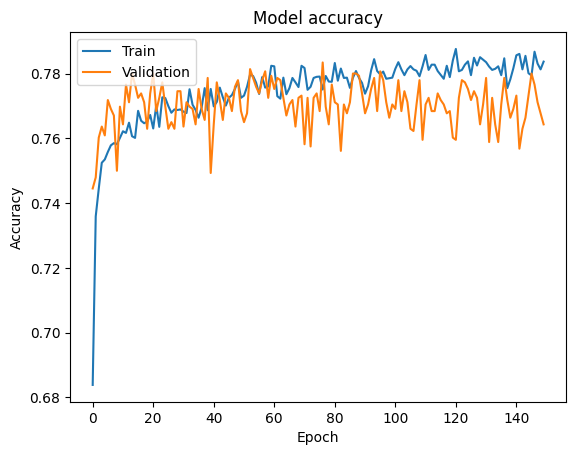

In [74]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [76]:
# Evaluate the nn model's performance on the train set
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print('Train Accuracy: %.3f' % train_acc)

# Evaluate the model's performance on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Validation Accuracy: %.3f' % val_acc)

# Evaluate the model's performance on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % test_acc)



Train Accuracy: 0.826
Validation Accuracy: 0.764
Test Accuracy: 0.784


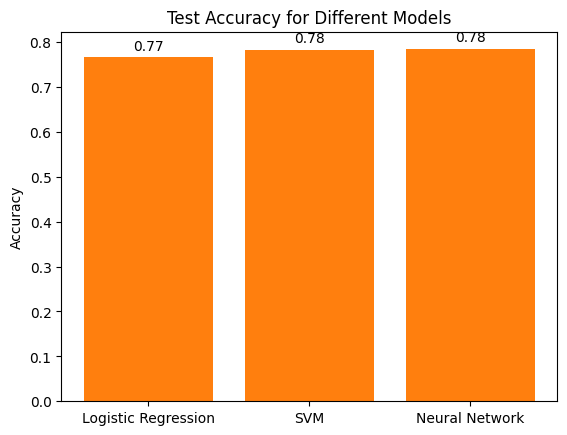

In [75]:
# Test accuracies for the three models
test_accuracies = [test_accuracy_lr, test_accuracy_svm, test_accuracy_nn]

# Model names
models = ['Logistic Regression', 'SVM', 'Neural Network']

# Create the bar chart
bars = plt.bar(models, test_accuracies)

# Add the accuracy numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Plot the test accuracies
plt.bar(models, test_accuracies)
plt.title('Test Accuracy for Different Models')
plt.ylabel('Accuracy')
plt.show()
